# 3D analysis of sequential DNA-FISH data with pyHiM



This notebook demonstrates the basic usage of pyHiM and explains each aspect of the analysis of sequential DNA-FISH data. Test datasets can be downloaded [here](enterthelocationhere):
    
The notebook is decomposed into 6 sections that illustrate each aspect of the analysis.

    - Section 0 : Selection of dataset 
    - Section 1 : Creation of Z-projections
    - Section 2 : Global 2D registration
    - Section 3 : Local 3D registration
    - Section 4 : Segmentation and localization
    - Section 5 : Building chromatin traces and pair-wise distance matrices

In [1]:
# Import python packages
from Jupyter_functions_plots import *
import os

# Enable inline plots
%matplotlib inline

In [2]:
# Basic check of PyHiM installation 
! pyhim --help

/bin/bash: line 1: pyhim: command not found


<div class="alert alert-block alert-info">
For more information please refer to the <a href="https://pyhim.readthedocs.io/en/latest/user_guide/pyhim_presentation.html">Online Documentation</a> </div>  


## Section 0/5: Selection of dataset

Download the basic dataset [here](). Unzip the dataset in a folder of your choice. These datasets were acquired using qudi-HiM (Barho et al. 2022).     

The folder containing the dataset has to be indicated in the next block under the variable `Input_folder`.

#### Nuclei
This input dataset contains:
- a DAPI image of nuclei (collected at 405 nm): scan_006_DAPI_001_ROI_converted_decon_ch00.tif
- the corresponding fiducial for the DAPI image (collected at 561 nm): scan_006_DAPI_001_ROI_converted_decon_ch01.tif

These 3D images are collected only once per region of interest (ROI).

#### Barcodes
- barcode image for cycle `RTX` (collected at 647nm):scan_001_RTX_001_ROI_converted_decon_ch01.tif           
- the corresponding fiducial for cycle `RTX` (collected at 561nm): scan_001_RTX_001_ROI_converted_decon_ch00.tif 

These 3D images are collected for each cycle of hybridization, for each ROI.

To speed up execution, the images in the dataset contain only a region of 512x512x60 at the center of the field of view of the original images. Only 2 barcode images and their corresponding fiducials are provided for the test.

#### Localization table
A localization table is located in the `segmentedObjects` folder. This table (`segmentedObjects_3D_barcode_original.dat`) was generated using the full field of view and 25 barcodes.


In [2]:
# Indicate the directory that contain the dataset to use
Input_folder ='/mnt/grey/DATA/users/marcnol/test_HiM/olivier_pancreas/rawData_2022_Exp6_ROI5/test_dataset_512/'
os.chdir(Input_folder)
print(f"The current working directory: {os.path.abspath(os.curdir)}")

The current working directory: /mnt/grey/DATA/users/marcnol/test_HiM/olivier_pancreas/rawData_2022_Exp6_ROI5/test_dataset_512


### Section 1/5: Creation of Z-projections

    
The `makeProjections` module with project the 3D input images in 2D, using the method specified in the `infoList.json` file (default: maximum intensity projection). This step is required for the registration of XY mechanical shifts, and for 2D segmentations.


In [4]:
%%capture 
#To hide the terminal outputs, uncomment if you want to display them

# Execute makeProjections 
! pyhim -C makeProjections

#### DAPI projections

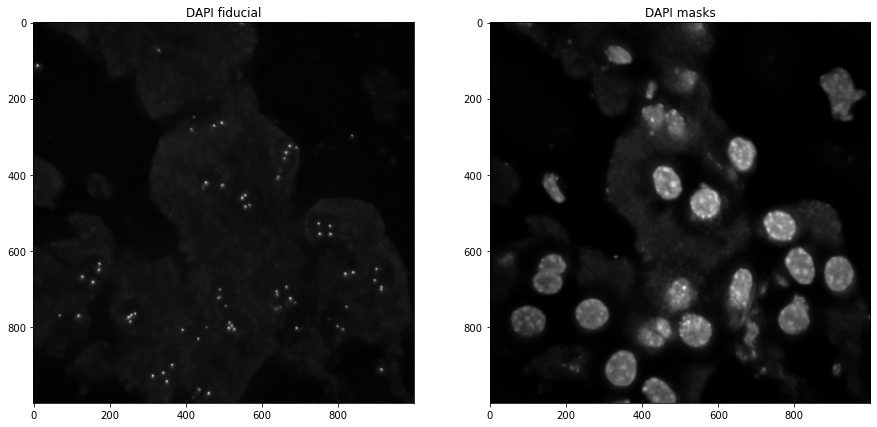

In [3]:
# Set datatype ('DAPI','RT')
datatype = 'DAPI'

# Set titles 
titles = ['DAPI fiducial','DAPI masks']

# Display DAPI and fiducial signal   
plot_zprojection(Input_folder,_,titles,datatype)

#### Barcode projections

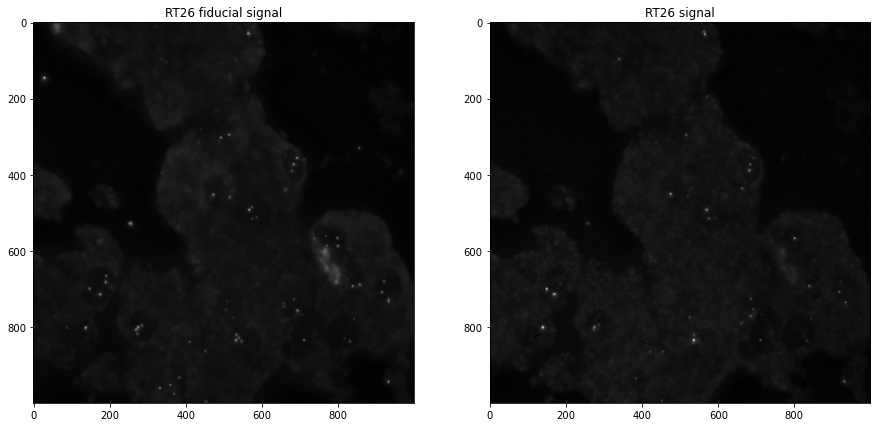

In [4]:
# Set datatype ('DAPI','RT')
datatype = 'RT'

# Set reference RTs
RTs_references = 'RT26' 

# Set titles 
titles = [RTs_references+' fiducial signal',RTs_references+' signal']

# Display RTs and fiducial signal        
plot_zprojection(Input_folder,RTs_references,titles,datatype)

### Section 2/5: Registration

This section will use fiducial images to register images to correct the mechanical drift of the microscope. For this, a reference barcode fiducial needs to be provided in the infoList.json file. The `alignImages` method will find the shifts in XY that best registers the fiducial images. The `appliesRegistrations` method will apply these shifts to the DAPI and barcode images. Different methods for global alignment are available, please see the [alignImages user documentation](https://pyhim.readthedocs.io/en/latest/user_guide/fundamental.html#alignimages) for more imformation.

In [30]:
%%capture
# Indicate the directory that contains the test dataset
os.chdir(Input_folder)

# Execute the alignment 
! pyhim -C alignImages,appliesRegistrations

#### Displaying results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


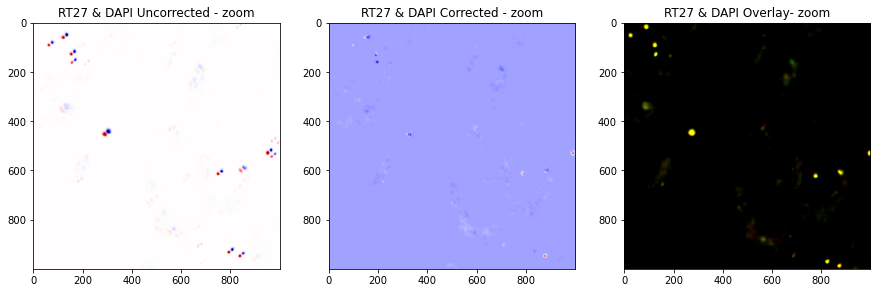

In [3]:
# Set figure titles
cycle = 'RT27'
titles = [cycle+' & DAPI '+'Uncorrected - zoom',cycle+' & DAPI '+'Corrected - zoom',cycle+' & DAPI '+'Overlay- zoom']

# Display alignement results 
plot_alignment(Input_folder,cycle,titles)

The left panel contains the difference between the fiducial image of the reference barcode (RT26, red) and the fiducial of the DAPI image (blue). The middle panel contains same difference image but for drift registered images. In this middle map, red and blue spots should disappear if images were correctly registered. The right panel shows the two registered images in RGB. Regions of perfect co-localization appear in yellow.  

### Section 3/5: Local 3D registration

This section will try to improve the global 2D registration from the previous module by taking into account local deformations of the sample. In addition, this function will check and correct residual Z-drifts that may have occurred despite the use of an auto-focus control system. Different methods and options are available, please see the [alignImages3D user documentation](https://pyhim.readthedocs.io/en/latest/user_guide/fundamental.html#alignimages3d) for more information.

In [32]:
%%capture

! pyhim -C alignImages3D

#### Displaying results

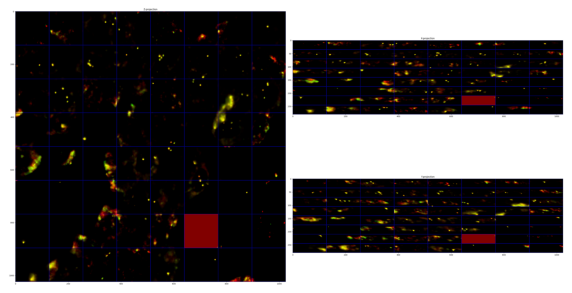

In [5]:
# Display block alignments in 3D: XY (left panel), XZ-YZ (right panels) 
plot_matrix(Input_folder,data_type='3D_alignments,RT27')

### Section 4/5: Mask segmentation and barcode localization

This section will process the segmentation of nuclei images using AI-based methods. For more details, see the [segmentMasks3D user guide](https://pyhim.readthedocs.io/en/latest/user_guide/fundamental.html#segmentmasks3d). 

In [34]:
%%capture

! pyhim -C segmentMasks3D

#### Displaying results


$ Will plot: ['/mnt/grey/DATA/users/marcnol/test_HiM/olivier_pancreas/rawData_2022_Exp6_ROI5/test_dataset_512/segmentedObjects/scan_001_DAPI_005_ROI_converted_decon_ch00.tif_3Dmasks.png']


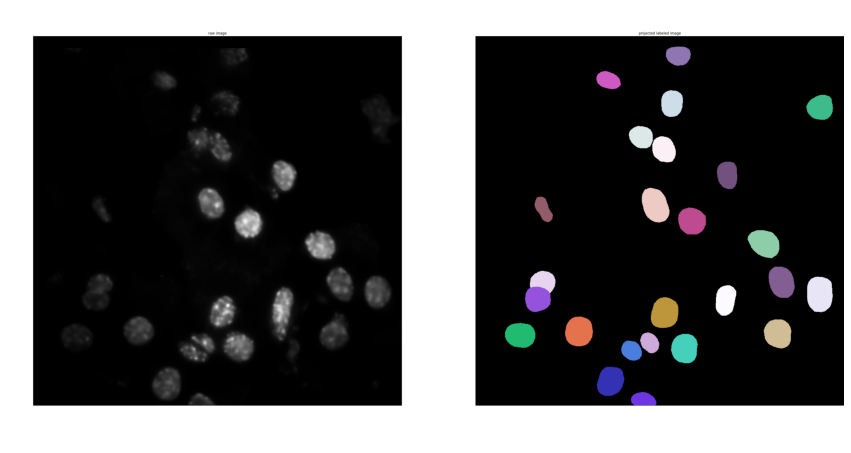

In [5]:
# Set datatype ('DAPI','RT','TRACES')
datatype = 'DAPI'

# Set titles
titles = ['DAPI raw','DAPI segmented']

# Display segmented DAPI masks
plot_segment_object(Input_folder,_,titles,datatype)

### Segmentation and 3D localization of barcodes

This section will segment barcodes using AI-based methods and then localize the center of each barcode using 3D gaussian fitting. For more details, see the [segmentSources3D user guide](https://pyhim.readthedocs.io/en/latest/user_guide/fundamental.html#segmentsources3d). 

In [42]:
%%capture

! pyhim -C segmentSources3D

#### Displaying results

$ Will plot: ['/mnt/grey/DATA/users/marcnol/test_HiM/olivier_pancreas/rawData_2022_Exp6_ROI5/test_dataset_512/segmentedObjects/scan_001_RT26_005_ROI_converted_decon_ch01.tif_3DimageNlocalizations.png']


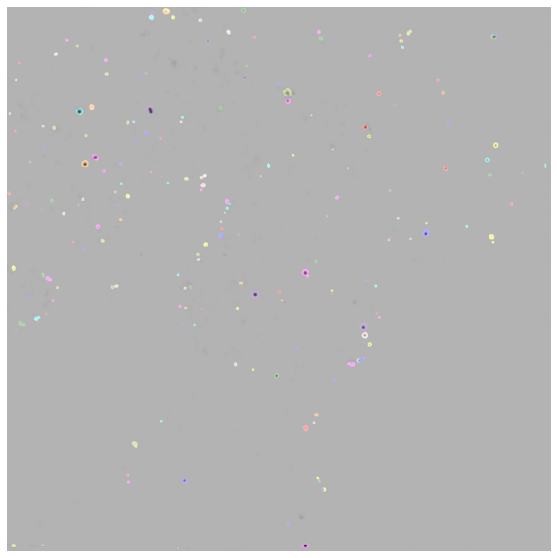

In [6]:
# Set datatype ('DAPI','RT','TRACES')
datatype = 'RT'
RTs_references = 'RT26' 

# Set titles
titles = [RTs_references+' Segmented ']

# Display segmented barcode masks
plot_segment_object(Input_folder,RTs_references,titles,datatype)

### Section 5/5: Building chromatin traces and pair-wise distance matrices

This section will build chromatin trace tables from the barcode localization tables, and from these calculate  pairwise distance (PWD) matrices for each trace.

In sections 1-4/5, we have provided a very small dataset with only two barcodes and a reduced field of view (512x512x60). In this section, we will provide you with a localization matrix containing data from 25 barcodes over a full field of view (2048x2048x60). This localization table will be used to build chromatin traces and from these construct pair-wise distance and proximity maps.

#### Building chromatin traces

In [6]:
%%capture

# copies localization table
copy_localization_table(Input_folder)

# builds traces
! pyhim -C build_traces

#### Displaying chromatin traces

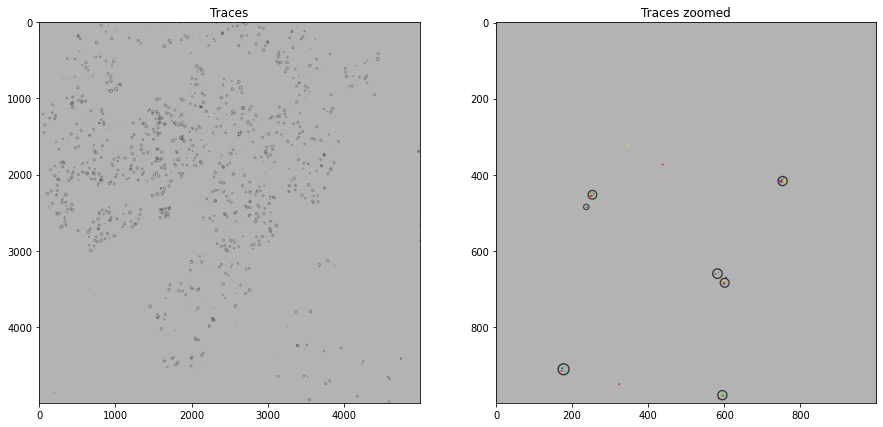

In [5]:
# Set datatype ('DAPI','RT','TRACES')
datatype = 'TRACES'

# Set titles
titles = ['Traces','Traces zoomed']

# Display traces
plot_segment_object(Input_folder,_,titles,datatype)

#### Building pairwise distance and proximity maps

In [ ]:
%%capture

# builds traces
! pyhim -C build_matrix

#### Displaying pairwise distance and proximity maps

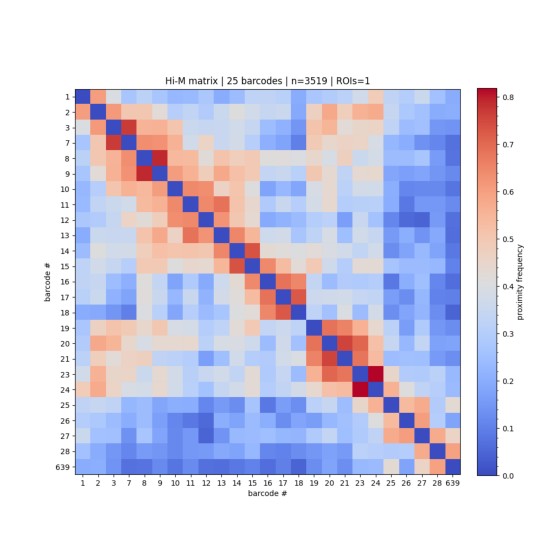

In [6]:
# Display the HiM proximity matrix 
plot_matrix(Input_folder,data_type='proximity')

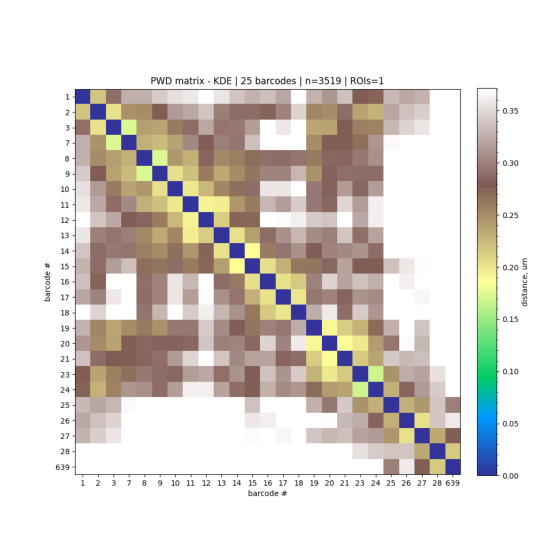

In [7]:
# Display the PWD matrix 
plot_matrix(Input_folder,data_type='PWD')